# Importing packages and files

In [1]:
import json
import graphviz
import requests
from IPython.display import display
from anytree.exporter import DotExporter
import sys

sys.path.append('simulator/src')

URL = "127.0.0.1"
PORT = 8001

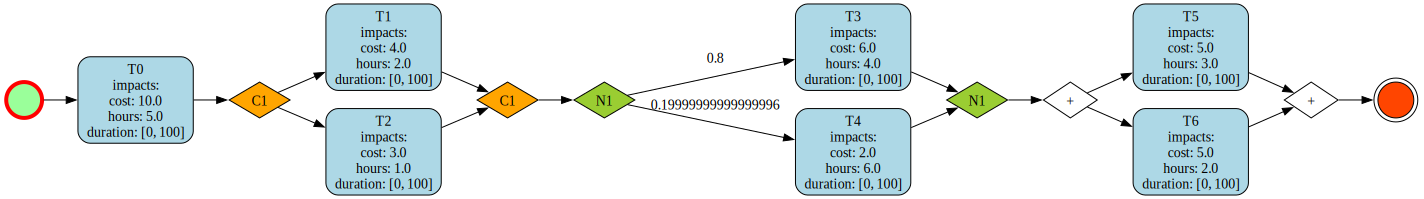

In [2]:
from src.utils.env import EXPRESSION, IMPACTS, DURATIONS, IMPACTS_NAMES, PROBABILITIES, DELAYS, LOOP_PROBABILITY, LOOP_ROUND, H
import graphviz
from IPython.display import display, SVG

# A string that describing the full BPMN structure.
expression = "T0, (T1 / [C1] T2), (T3 ^ [N1] T4), (T5 || T6)"


bpmn = {
	EXPRESSION: expression,
	H: 0,
	# A dictionary mapping task names to impact vectors (e.g., cost and hours)
	IMPACTS: {"T0": [10, 5], "T1": [4, 2], "T2": [3, 1], "T3": [6, 4],
			  "T4": [2, 6], "T5": [5, 3], "T6": [5, 2]},
	# A dictionary mapping task names to [min_time, max_time] execution time
	DURATIONS: {"T0": [0, 100], "T1": [0, 100], "T2": [0, 100], "T3": [0, 100],
				"T4": [0, 100], "T5": [0, 100], "T6": [0, 100]},
	# A list of names corresponding to the dimensions of the impacts
	IMPACTS_NAMES: ["cost", "hours"],
	# A dictionary mapping nature labels to their execution probabilities for the left child.
	PROBABILITIES: {"N1": 0.8},
	# A dictionary mapping choice to their delay values.
	DELAYS: {"C1": 0},
	LOOP_PROBABILITY : {}, LOOP_ROUND: {}
}

try:
	resp = requests.get(f'http://{URL}:{8000}/create_bpmn', json={'bpmn': bpmn},  headers={"Content-Type": "application/json"})
	resp.raise_for_status()
	parse_tree = resp.json()["parse_tree"]
	display(SVG(graphviz.Source(resp.json()['bpmn_dot']).pipe(format="svg")))

except requests.exceptions.HTTPError as e:
	print(f"HTTP Error ({resp.status_code}):", resp.json())

In [3]:
parse_tree

{'id': 0,
 'index_in_parent': 0,
 'type': 'sequential',
 'children': [{'id': 1,
   'index_in_parent': 0,
   'type': 'sequential',
   'children': [{'id': 2,
     'index_in_parent': 0,
     'type': 'sequential',
     'children': [{'id': 3,
       'index_in_parent': 0,
       'type': 'task',
       'label': 'T0',
       'impacts': [10.0, 5.0],
       'duration': [0, 100]},
      {'max_delay': 0,
       'label': 'C1',
       'id': 4,
       'index_in_parent': 1,
       'type': 'choice',
       'children': [{'id': 5,
         'index_in_parent': 0,
         'type': 'task',
         'label': 'T1',
         'impacts': [4.0, 2.0],
         'duration': [0, 100]},
        {'id': 6,
         'index_in_parent': 1,
         'type': 'task',
         'label': 'T2',
         'impacts': [3.0, 1.0],
         'duration': [0, 100]}]}]},
    {'distribution': [0.8, 0.19999999999999996],
     'label': 'N1',
     'id': 7,
     'index_in_parent': 1,
     'type': 'nature',
     'children': [{'id': 8,
       'ind

# Initialize petri net and execution tree

In [4]:
response = requests.post(f"http://{URL}:{PORT}/execute", headers={"Content-Type": "application/json"},
                         json={"bpmn": parse_tree})
response_json = response.json()

In [5]:
parse_tree = response_json['bpmn']
petri_net = response_json['petri_net']
petri_net_dot = response_json['petri_net_dot']
execution_tree = response_json['execution_tree']

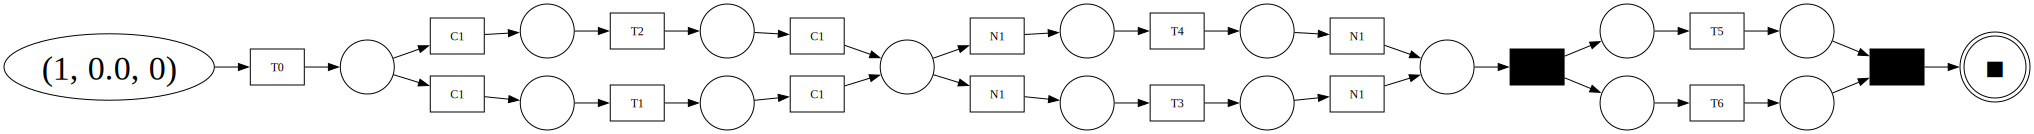

In [6]:
graph = graphviz.Source(petri_net_dot, format="svg")
display(graph)

# Execute choice

In [22]:
request_json = {
    'bpmn': parse_tree,
    'petri_net': petri_net,
    'petri_net_dot': petri_net_dot,
    'execution_tree': execution_tree,
    "time_step": 2.0,
    # 'choices': ['6'] # id delle transizioni con stop da eseguire, se non vengono passati vengono presi i default
}

response = requests.post(f"http://{URL}:{PORT}/execute", headers={"Content-Type": "application/json"},
						 json={"bpmn": parse_tree})
response_json = response.json()

In [23]:
parse_tree = response_json['bpmn']
petri_net = response_json['petri_net']
petri_net_dot = response_json['petri_net_dot']
execution_tree = response_json['execution_tree']

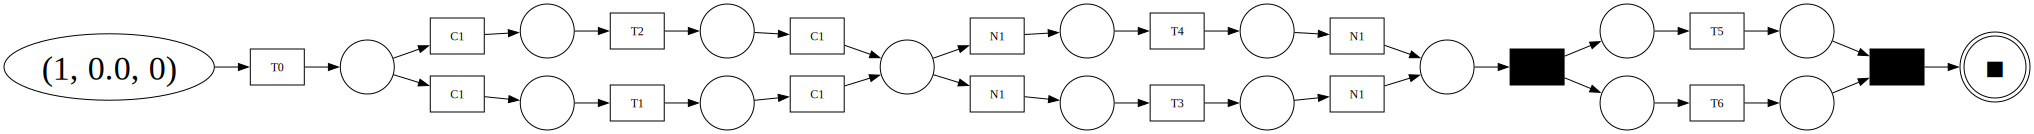

In [24]:
graph = graphviz.Source(petri_net_dot, format="svg")
display(graph)

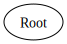

In [10]:
from model.endpoints.execute.request import ExecuteRequest

model = ExecuteRequest.model_validate_json(response.text)
extree = model.execution_tree_obj
extree_dot = "\n".join(DotExporter(extree.root))
display(graphviz.Source(extree_dot))

# Display BPMN

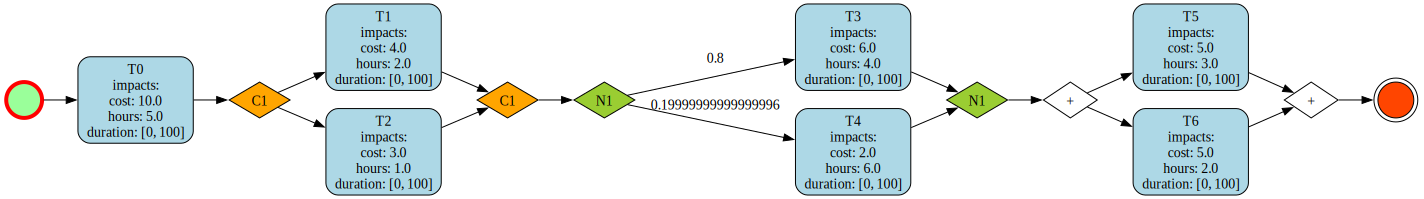

In [11]:


from dot import get_active_region_by_pn

impacts_names = ["a", "b"]
marking = {"21": {"token": 1}, "7": {"token": 1}}

resp = requests.get(f"http://{URL}:{8000}/create_bpmn",
					json={
						"bpmn": bpmn,
						"active_regions": list(get_active_region_by_pn(petri_net, marking)),
						"is_initial": False,
						"is_final": False
					},
					headers={"Content-Type": "application/json"})
resp.raise_for_status()

dot =  resp.json()["bpmn_dot"]
graph = graphviz.Source(dot, format="svg")

display(graph)

# Display Execution Tree

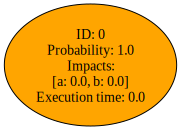

In [12]:
from src.paco.parser.dot.execution_tree import get_path_to_current_node, get_execution_tree_dot

current_path = get_path_to_current_node(execution_tree.get("root",{}), execution_tree.get("current_node"))
dot = get_execution_tree_dot(execution_tree.get("root", {}), impacts_names, current_path)
graph = graphviz.Source(dot, format="svg")
display(graph)